# Library Import

In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift
import math
import mne
base_dir = os.getcwd()
print(f'current directory: {base_dir}')
dataset_dir = os.path.join(base_dir, 'datasets')
print(f'datasets directory: {dataset_dir}')

current directory: /Users/delphia/Desktop/final_project
datasets directory: /Users/delphia/Desktop/final_project/datasets


# Basic Functions

In [11]:
def read_A_dataset(path, case_str):
  case_path = os.path.join(path, case_str)
  subjects_list = []
  for filename in os.listdir(case_path):
    with open(os.path.join(case_path, filename), 'r') as f:
      lines = f.readlines()
      subjects_list.append(lines)
  return subjects_list

# -----------------------------------------
def convert_to_numbers(sub_list):
  new_list = []
  for sub in sub_list:
    new_list.append([float(value) for value in sub])
  return new_list

# -----------------------------------------
def list_segments(lst, segments=16):
  arr = np.array(lst)
  return np.array_split(np.array(arr), segments)


# --------------------------------------------
def divide_to_channels(subjects_list, segments=16):
  return [list_segments(subject, segments) for subject in subjects_list]


# ----------------------------------------------
def log_data_shapes(sch, norm):
  return {
 'sch': (len(sch), len(sch[0]), sch[0][0].shape),
 'norm': (len(norm), len(norm[0]), norm[0][0].shape)}

# 1. different Channels

In [6]:
recording_len = 7680
freq = 128
total_time = recording_len // freq
print(f'the recording is {total_time} seconds long and has total {recording_len} values')

the recording is 60 seconds long and has total 7680 values


In [20]:
def create_spectrograms(eeg_data, fs=128, nperseg=256, noverlap=128):
    """
    Create spectrograms from EEG channel data
    
    Parameters:
    -----------
    eeg_data : array-like
        EEG channel data with shape (7680,)
    fs : int
        Sampling frequency (128 Hz)
    nperseg : int
        Length of each segment for STFT
    noverlap : int
        Number of points to overlap between segments
    
    Returns:
    --------
    f : array
        Frequency bins
    t : array
        Time points
    Sxx : 2D array
        Spectrogram data (power spectral density)
    """
    f, t, Sxx = signal.spectrogram(eeg_data, fs=fs, nperseg=nperseg, 
                                  noverlap=noverlap, scaling='density')
    return f, t, Sxx

def plot_spectrogram(f, t, Sxx, channel_name=None, plot_title=None):
    """
    Plot a spectrogram with no axes for CNN processing
    """
    plt.figure(figsize=(4, 4))
    plt.axis('off')  # Turn off all axes
    
    # Plot the spectrogram
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    
    # Set limits to ensure it shows 60 seconds
    plt.xlim(0, 60)
    
    # Optional title
    if channel_name and plot_title:
        plt.title(f"{plot_title} - Channel: {channel_name}")
    elif channel_name:
        plt.title(f"Channel: {channel_name}")
    elif plot_title:
        plt.title(plot_title)
    
    plt.tight_layout()
    plt.show()

In [21]:
colors = ['black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow',
          'black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow']

channels_16 = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
               'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

def plot_signals(data, subject_index=0, n_channels=16):
  fig = plt.figure(figsize=(20, 10), dpi=100)
  gs = gridspec.GridSpec(n_channels, 1)

  for i in range(0, n_channels):
    ax = plt.subplot(gs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    line, = ax.plot(data[subject_index][i], color=colors[i])
    ax.set_yticklabels([])
    ax.set_ylabel(f'{channels_16[i]}')
    plt.xlim([0, recording_len])

  # remove vertical gap between subplots
  plt.subplots_adjust(hspace=.0)
  plt.show()

## Spectrograms data

In [12]:
norm_raw_data = convert_to_numbers(read_A_dataset(dataset_dir, 'norm'))
sch_raw_data = convert_to_numbers(read_A_dataset(dataset_dir, 'sch'))
print(f'no. subjects = norm: {len(norm_raw_data)}, sch:{len(sch_raw_data)}')
sch_channels = divide_to_channels(sch_raw_data)
norm_channels = divide_to_channels(norm_raw_data)
print('shapes: ', log_data_shapes(sch_channels, norm_channels))

no. subjects = norm: 39, sch:45
shapes:  {'sch': (45, 16, (7680,)), 'norm': (39, 16, (7680,))}


In [31]:
f,t,Sxx = create_spectrograms(sch_channels[0][1])

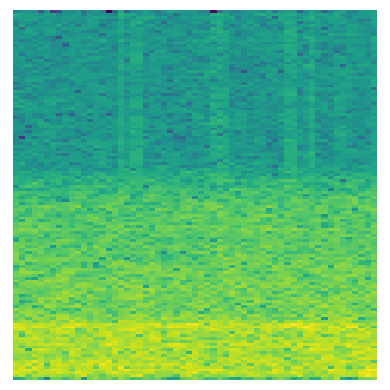

In [32]:
plot_spectrogram(f, t, Sxx)

In [16]:
# print("\n16 channel plot of one schizophernic subject")
# plot_signals(sch_channels,0)
# print("\n16 channel plot of one healthy subject ")
# plot_signals(norm_channels, 2)

In [33]:
def export_spectrograms(data_list, output_dir, class_name, fs=128, nperseg=256, noverlap=128):
    """
    Generate and save spectrograms for all subjects and channels
    
    Parameters:
    -----------
    data_list : list
        List of subject data
    output_dir : str
        Directory to save the spectrograms
    class_name : str
        Class name (e.g., 'schizophrenia' or 'normal')
    fs, nperseg, noverlap : int
        Spectrogram parameters
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create class directory
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    for subject_idx, subject_data in enumerate(data_list):
        # Create subject directory
        subject_dir = os.path.join(class_dir, f'subject_{subject_idx+1:03d}')
        os.makedirs(subject_dir, exist_ok=True)
        
        for channel_idx, channel_data in enumerate(subject_data):
            # Create spectrogram
            f, t, Sxx = create_spectrograms(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
            
            # Create figure
            fig = plt.figure(figsize=(4, 4), dpi=100)
            plt.axis('off')
            plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
            plt.xlim(0, 60)
            
            # Save figure
            channel_name = channels_16[channel_idx]
            filename = os.path.join(subject_dir, f'channel_{channel_name}.png')
            plt.savefig(filename, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            
            # Print progress update occasionally
            if channel_idx % 4 == 0:
                print(f"Processed {class_name} subject {subject_idx+1}/{len(data_list)}, channel {channel_idx+1}/{len(subject_data)}")

# Example usage:
output_directory = "./spectrograms"
export_spectrograms(sch_channels, output_directory, "schizophrenia")
export_spectrograms(norm_channels, output_directory, "normal")

Processed schizophrenia subject 1/45, channel 1/16
Processed schizophrenia subject 1/45, channel 5/16
Processed schizophrenia subject 1/45, channel 9/16
Processed schizophrenia subject 1/45, channel 13/16
Processed schizophrenia subject 2/45, channel 1/16
Processed schizophrenia subject 2/45, channel 5/16
Processed schizophrenia subject 2/45, channel 9/16
Processed schizophrenia subject 2/45, channel 13/16
Processed schizophrenia subject 3/45, channel 1/16
Processed schizophrenia subject 3/45, channel 5/16
Processed schizophrenia subject 3/45, channel 9/16
Processed schizophrenia subject 3/45, channel 13/16
Processed schizophrenia subject 4/45, channel 1/16
Processed schizophrenia subject 4/45, channel 5/16
Processed schizophrenia subject 4/45, channel 9/16
Processed schizophrenia subject 4/45, channel 13/16
Processed schizophrenia subject 5/45, channel 1/16
Processed schizophrenia subject 5/45, channel 5/16
Processed schizophrenia subject 5/45, channel 9/16
Processed schizophrenia sub

# 2. Averaging Approach

In [66]:
def create_averaged_channel_spectrogram(subject_data, fs=128, nperseg=256, noverlap=128):
    """
    Create a single spectrogram by averaging all channels for a subject
    
    Parameters:
    -----------
    subject_data : list of arrays
        List of EEG channel data arrays, each with shape (7680,)
    fs : int
        Sampling frequency (128 Hz)
    nperseg, noverlap : int
        STFT parameters
    
    Returns:
    --------
    f : array
        Frequency bins
    t : array
        Time points
    Sxx : 2D array
        Spectrogram data from averaged channels
    """
    # Convert each channel to numpy array if not already
    subject_data_arrays = [np.array(channel) for channel in subject_data]
    
    # Average across all channels
    averaged_data = np.mean(subject_data_arrays, axis=0)
    
    # Create spectrogram from the averaged data
    f, t, Sxx = create_spectrograms(averaged_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    return f, t, Sxx

def process_all_subjects_averaged(data_list, fs=128, nperseg=256, noverlap=128):
    """
    Process all subjects using the channel averaging approach
    
    Parameters:
    -----------
    data_list : list
        List of subject data
    fs, nperseg, noverlap : int
        Spectrogram parameters
    
    Returns:
    --------
    all_spectrograms : list
        List of (f, t, Sxx) tuples for each subject
    """
    all_spectrograms = []
    
    for subject_idx, subject_data in enumerate(data_list):
        # Create averaged spectrogram
        f, t, Sxx = create_averaged_channel_spectrogram(subject_data, fs, nperseg, noverlap)
        all_spectrograms.append((f, t, Sxx))
        
        # Print progress occasionally
        if (subject_idx + 1) % 5 == 0:
            print(f"Processed {subject_idx + 1}/{len(data_list)} subjects")
    
    return all_spectrograms

def save_averaged_spectrograms(data_list, output_dir, class_name, fs=128, nperseg=256, noverlap=128):
    """
    Save averaged channel spectrograms as images
    
    Parameters:
    -----------
    data_list : list
        List of subject data
    output_dir : str
        Directory to save the spectrograms
    class_name : str
        Class name (e.g., 'schizophrenia' or 'normal')
    fs, nperseg, noverlap : int
        Spectrogram parameters
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    for subject_idx, subject_data in enumerate(data_list):
        # Create averaged spectrogram
        f, t, Sxx = create_averaged_channel_spectrogram(subject_data, fs, nperseg, noverlap)
        
        # Convert to dB scale
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        
        # Create and save figure
        fig = plt.figure(figsize=(4, 4), dpi=100)
        plt.axis('off')
        plt.pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='viridis')
        plt.xlim(0, 60)
        
        # Save figure
        filename = os.path.join(class_dir, f'subject_{subject_idx+1:03d}.png')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        
        # Print progress occasionally
        if (subject_idx + 1) % 5 == 0:
            print(f"Saved {subject_idx + 1}/{len(data_list)} {class_name} spectrograms")

def test_averaged_spectrogram(data_list, subject_idx=0, include_axes=True):
    """
    Test the averaged channel spectrogram approach on a single subject
    
    Parameters:
    -----------
    data_list : list
        List of subject data
    subject_idx : int
        Index of the subject to test
    include_axes : bool
        Whether to include axes and labels (True) or create a clean image (False)
    """
    subject_data = data_list[subject_idx]
    print(f"Subject data has {len(subject_data)} channels, each with {len(subject_data[0])} samples")
    
    # Create averaged spectrogram
    f, t, Sxx = create_averaged_channel_spectrogram(subject_data)
    
    # Display information
    print(f"Spectrogram shape: {Sxx.shape}")
    print(f"Frequency range: {f.min():.2f} to {f.max():.2f} Hz")
    print(f"Time range: {t.min():.2f} to {t.max():.2f} seconds")
    
    # Plot spectrogram
    if include_axes:
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
        plt.colorbar(label='Power/Frequency (dB/Hz)')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(f"Subject {subject_idx+1} - Averaged Channels Spectrogram")
        plt.ylim(0, 64)  # Limit to relevant EEG frequency range
        plt.xlim(0, 60)  # Show full 60-second recording
    else:
        # Clean version without axes for CNN processing
        plot_spectrogram(f, t, Sxx, plot_title=f"Subject {subject_idx+1} - Averaged Channels")
    
    plt.tight_layout()
    plt.show()
    
    return f, t, Sxx

In [37]:
norm_raw_data = convert_to_numbers(read_A_dataset(dataset_dir, 'norm'))
sch_raw_data = convert_to_numbers(read_A_dataset(dataset_dir, 'sch'))
print(f'no. subjects = norm: {len(norm_raw_data)}, sch:{len(sch_raw_data)}')
sch_channels = divide_to_channels(sch_raw_data)
norm_channels = divide_to_channels(norm_raw_data)
print('shapes: ', log_data_shapes(sch_channels, norm_channels))

no. subjects = norm: 39, sch:45
shapes:  {'sch': (45, 16, (7680,)), 'norm': (39, 16, (7680,))}


Subject data has 16 channels, each with 7680 samples
Spectrogram shape: (129, 59)
Frequency range: 0.00 to 64.00 Hz
Time range: 1.00 to 59.00 seconds


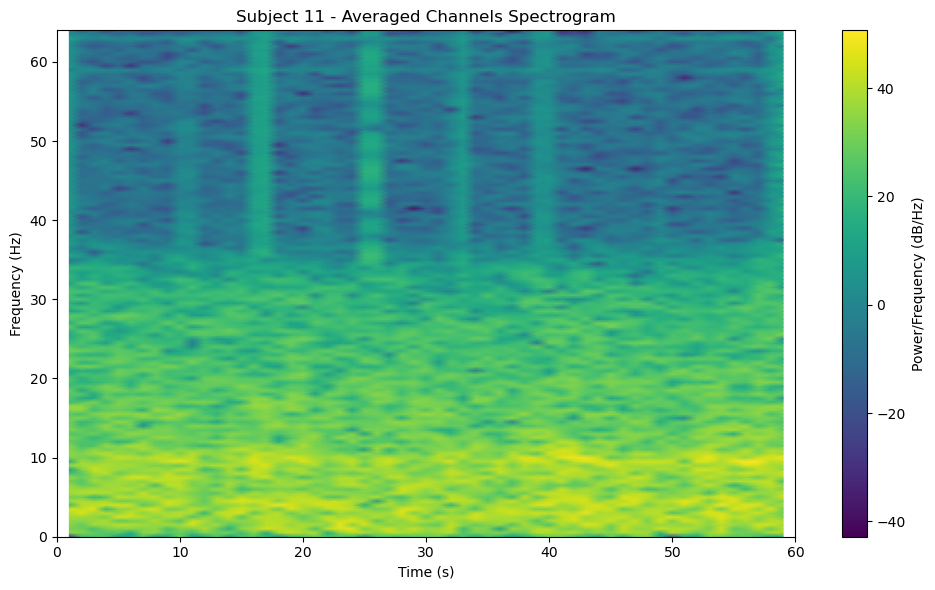

(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
        33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
        38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
        44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
        49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
        55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ,
        60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. ]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23

In [67]:
test_averaged_spectrogram(sch_channels, subject_idx=10)

Subject data has 16 channels, each with 7680 samples
Spectrogram shape: (129, 59)
Frequency range: 0.00 to 64.00 Hz
Time range: 1.00 to 59.00 seconds


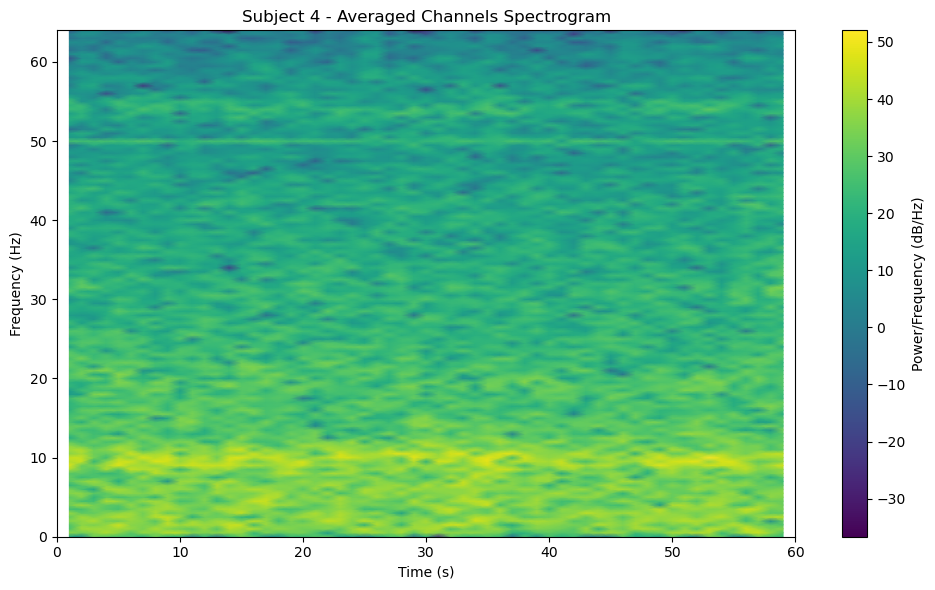

(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
        33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
        38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
        44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
        49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
        55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ,
        60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. ]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23

In [68]:
test_averaged_spectrogram(norm_channels, subject_idx=3)

In [45]:
output_dir = "./spectrograms_averaged"
save_averaged_spectrograms(sch_channels, output_dir, "schizophrenia")
save_averaged_spectrograms(norm_channels, output_dir, "normal")

Saved 5/45 schizophrenia spectrograms
Saved 10/45 schizophrenia spectrograms
Saved 15/45 schizophrenia spectrograms
Saved 20/45 schizophrenia spectrograms
Saved 25/45 schizophrenia spectrograms
Saved 30/45 schizophrenia spectrograms
Saved 35/45 schizophrenia spectrograms
Saved 40/45 schizophrenia spectrograms
Saved 45/45 schizophrenia spectrograms
Saved 5/39 normal spectrograms
Saved 10/39 normal spectrograms
Saved 15/39 normal spectrograms
Saved 20/39 normal spectrograms
Saved 25/39 normal spectrograms
Saved 30/39 normal spectrograms
Saved 35/39 normal spectrograms


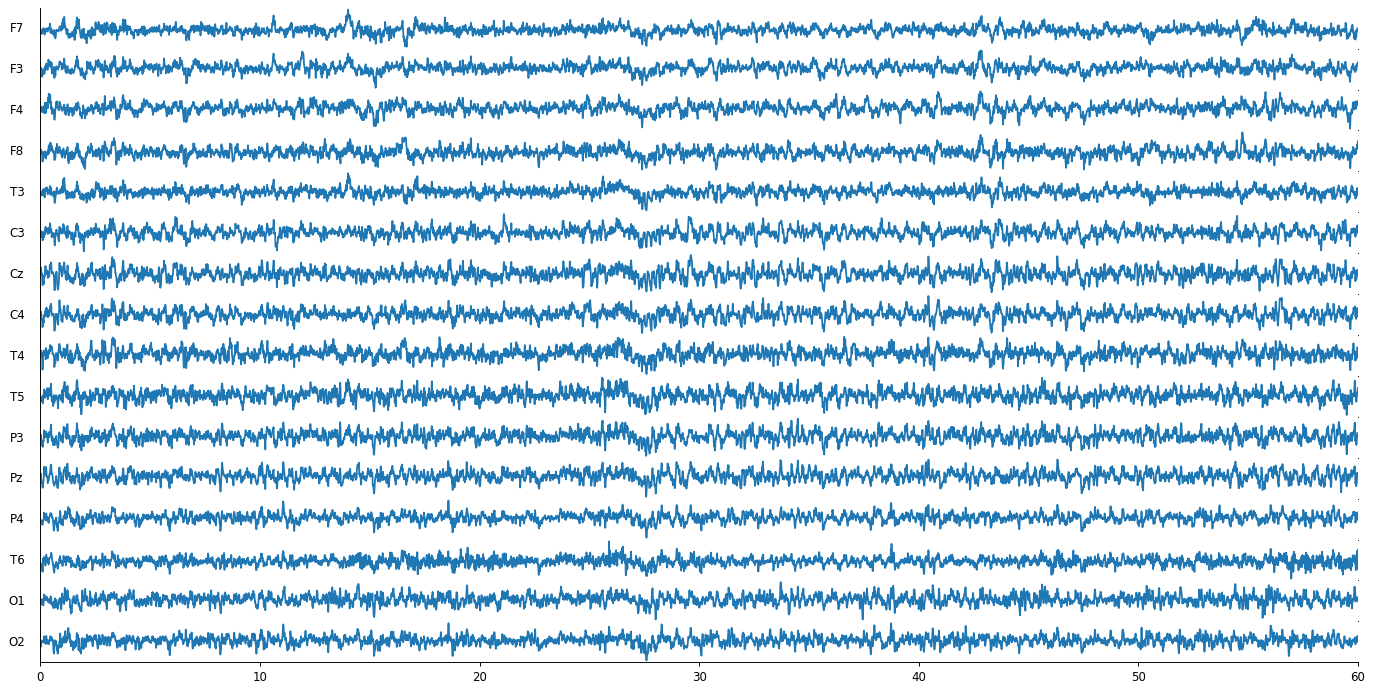

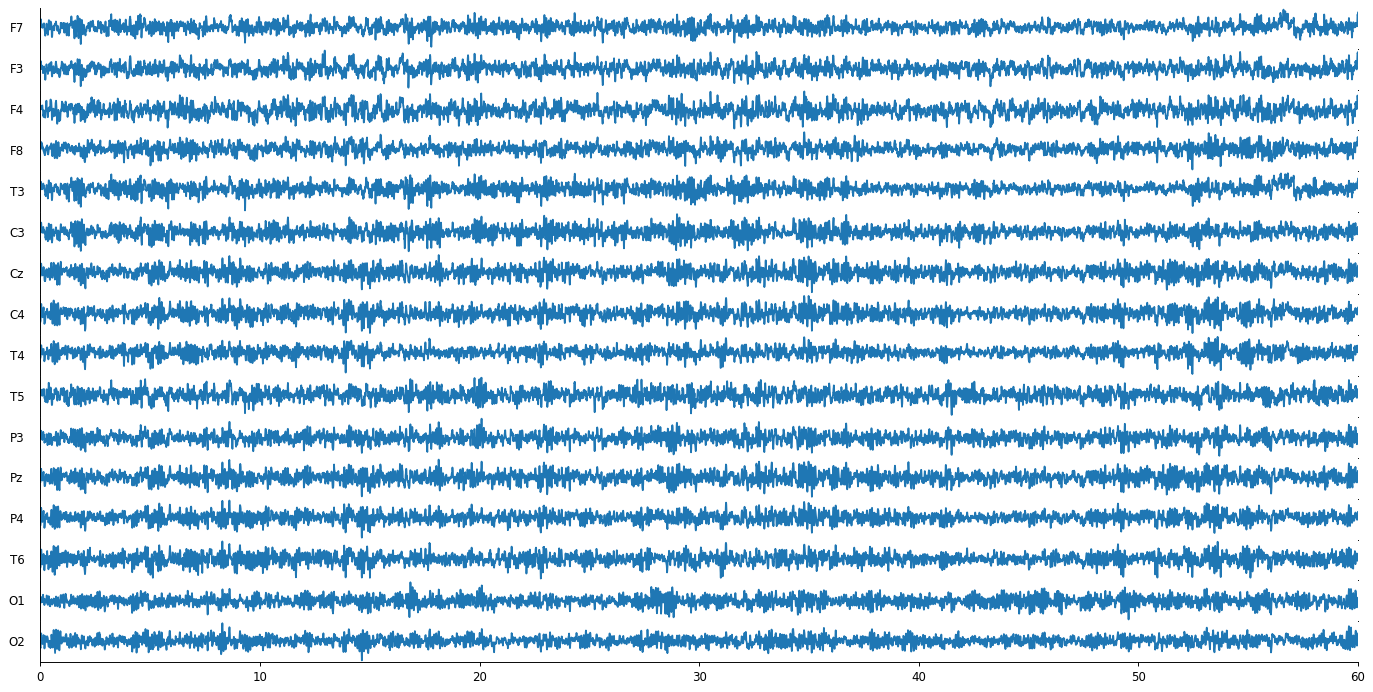

In [56]:
channels_16 = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
               'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

def plot_signals(data, subject_index=0, n_channels=16):
  fig = plt.figure(figsize=(20, 10), dpi=85)
  gs = gridspec.GridSpec(n_channels, 1)
  
  # Calculate time axis values (60 seconds for 7680 points)
  time_axis = np.linspace(0, 60, recording_len)

  for i in range(0, n_channels):
    ax = plt.subplot(gs[i])
    
    # Hide all spines
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.spines["right"].set_visible(False)
    
    # Plot against the time axis
    line, = ax.plot(time_axis, data[subject_index][i])
    
    # Remove y-axis ticks and labels completely
    ax.set_yticks([])
    ax.set_ylabel(f'{channels_16[i]}', rotation=0, labelpad=20, va='center')
    
    # Only show x-axis ticks for the bottom subplot
    if i < n_channels - 1:
        ax.set_xticks([])
    
    plt.xlim([0, 60])  # Set x-limit to 60 seconds

  # Remove vertical gap between subplots
  plt.subplots_adjust(hspace=.0)
  plt.show()
plot_signals(sch_channels, 3)
plot_signals(norm_channels, 3)



# RGB

In [13]:
def create_rgb_channel_spectrogram(subject_data, fs=128, nperseg=256, noverlap=128):
    """
    Create a color spectrogram where different brain regions are mapped to RGB color channels
    
    Parameters:
    -----------
    subject_data : list of arrays
        List of EEG channel data arrays, each with shape (7680,)
    fs : int
        Sampling frequency (128 Hz)
    nperseg, noverlap : int
        STFT parameters
    
    Returns:
    --------
    f : array
        Frequency bins
    t : array
        Time points
    rgb_image : 3D array
        RGB image data with dimensions (frequency bins, time points, 3)
    """
    # Group channels by brain region
    frontal_indices = [0, 1, 2, 3]          # F7, F3, F4, F8
    central_indices = [4, 5, 6, 7, 8, 9]    # T3, C3, Cz, C4, T4, T5
    posterior_indices = [10, 11, 12, 13, 14, 15]  # P3, Pz, P4, T6, O1, O2
    
    # Get frontal channels and create average spectrogram for red channel
    frontal_channels = [subject_data[i] for i in frontal_indices]
    frontal_avg = np.mean(frontal_channels, axis=0)
    f, t, Sxx_red = create_spectrograms(frontal_avg, fs, nperseg, noverlap)
    
    # Get central channels and create average spectrogram for green channel
    central_channels = [subject_data[i] for i in central_indices]
    central_avg = np.mean(central_channels, axis=0)
    _, _, Sxx_green = create_spectrograms(central_avg, fs, nperseg, noverlap)
    
    # Get posterior channels and create average spectrogram for blue channel
    posterior_channels = [subject_data[i] for i in posterior_indices]
    posterior_avg = np.mean(posterior_channels, axis=0)
    _, _, Sxx_blue = create_spectrograms(posterior_avg, fs, nperseg, noverlap)
    
    # Convert to dB scale for better visualization
    Sxx_red_db = 10 * np.log10(Sxx_red + 1e-10)
    Sxx_green_db = 10 * np.log10(Sxx_green + 1e-10)
    Sxx_blue_db = 10 * np.log10(Sxx_blue + 1e-10)
    
    # Find overall min and max for consistent scaling
    min_val = min(np.min(Sxx_red_db), np.min(Sxx_green_db), np.min(Sxx_blue_db))
    max_val = max(np.max(Sxx_red_db), np.max(Sxx_green_db), np.max(Sxx_blue_db))
    
    # Normalize each channel to 0-1 range for RGB image
    Sxx_red_norm = (Sxx_red_db - min_val) / (max_val - min_val)
    Sxx_green_norm = (Sxx_green_db - min_val) / (max_val - min_val)
    Sxx_blue_norm = (Sxx_blue_db - min_val) / (max_val - min_val)
    
    # Stack to create RGB image (transpose to get dimensions right)
    rgb_image = np.stack((Sxx_red_norm, Sxx_green_norm, Sxx_blue_norm), axis=-1)
    
    return f, t, rgb_image

def save_rgb_spectrograms(data_list, output_dir, class_name, fs=128, nperseg=256, noverlap=128):
    """
    Save RGB channel spectrograms as images
    
    Parameters:
    -----------
    data_list : list
        List of subject data
    output_dir : str
        Directory to save the spectrograms
    class_name : str
        Class name (e.g., 'schizophrenia' or 'normal')
    fs, nperseg, noverlap : int
        Spectrogram parameters
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    for subject_idx, subject_data in enumerate(data_list):
        # Create RGB spectrogram
        f, t, rgb_image = create_rgb_channel_spectrogram(subject_data, fs, nperseg, noverlap)
        
        # Create and save figure
        fig = plt.figure(figsize=(4, 4), dpi=100)
        plt.axis('off')
        plt.imshow(rgb_image, extent=[t.min(), t.max(), f.min(), f.max()], aspect='auto', origin='lower')
        plt.xlim(0, 60)
        
        # Save figure
        filename = os.path.join(class_dir, f'subject_{subject_idx+1:03d}.png')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        
        # Print progress occasionally
        if (subject_idx + 1) % 5 == 0:
            print(f"Saved {subject_idx + 1}/{len(data_list)} {class_name} RGB spectrograms")

In [29]:
output_dir = "./spectrograms_RGB"
save_rgb_spectrograms(sch_channels, output_dir, "schizophrenia")
save_rgb_spectrograms(norm_channels, output_dir, "normal")

Saved 5/45 schizophrenia RGB spectrograms
Saved 10/45 schizophrenia RGB spectrograms
Saved 15/45 schizophrenia RGB spectrograms
Saved 20/45 schizophrenia RGB spectrograms
Saved 25/45 schizophrenia RGB spectrograms
Saved 30/45 schizophrenia RGB spectrograms
Saved 35/45 schizophrenia RGB spectrograms
Saved 40/45 schizophrenia RGB spectrograms
Saved 45/45 schizophrenia RGB spectrograms
Saved 5/39 normal RGB spectrograms
Saved 10/39 normal RGB spectrograms
Saved 15/39 normal RGB spectrograms
Saved 20/39 normal RGB spectrograms
Saved 25/39 normal RGB spectrograms
Saved 30/39 normal RGB spectrograms
Saved 35/39 normal RGB spectrograms


In [22]:
def test_rgb_spectrogram(data_list, subject_idx=0):
    """
    Test the RGB channel spectrogram approach on a single subject
    
    Parameters:
    -----------
    data_list : list
        List of subject data
    subject_idx : int
        Index of the subject to test
    """
    subject_data = data_list[subject_idx]
    print(f"Subject data has {len(subject_data)} channels, each with {len(subject_data[0])} samples")
    
    # Create RGB spectrogram
    f, t, rgb_image = create_rgb_channel_spectrogram(subject_data)
    
    # Display information
    print(f"RGB image shape: {rgb_image.shape}")
    print(f"Frequency range: {f.min():.2f} to {f.max():.2f} Hz")
    print(f"Time range: {t.min():.2f} to {t.max():.2f} seconds")
    
    # Plot RGB spectrogram
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb_image, extent=[t.min(), t.max(), f.min(), f.max()], aspect='auto', origin='lower')
    plt.colorbar(label='Normalized Power')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.title(f"Subject {subject_idx+1} - RGB Channel Spectrogram")
    
    # Add a legend for the color channels
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Frontal (F7, F3, F4, F8)'),
        Patch(facecolor='green', label='Central/Temporal (T3, C3, Cz, C4, T4, T5)'),
        Patch(facecolor='blue', label='Posterior (P3, Pz, P4, T6, O1, O2)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Also show without axes for CNN processing
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.imshow(rgb_image, aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    return f, t, rgb_image

Subject data has 16 channels, each with 7680 samples
RGB image shape: (129, 59, 3)
Frequency range: 0.00 to 64.00 Hz
Time range: 1.00 to 59.00 seconds


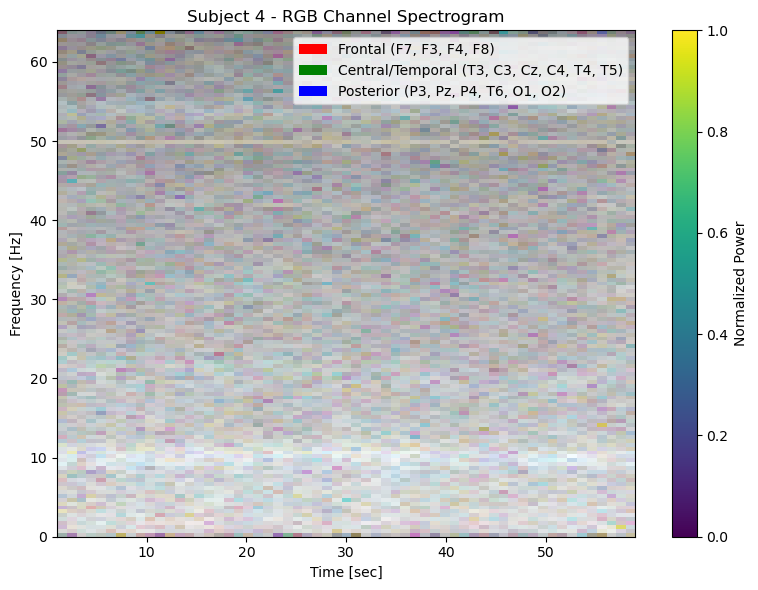

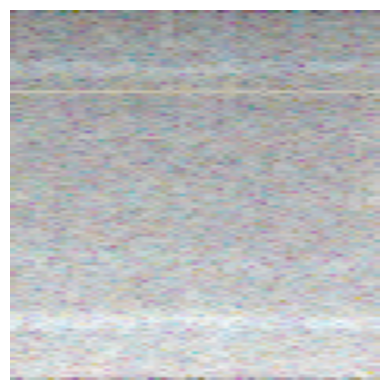

In [25]:
f, t, rgb_image = test_rgb_spectrogram(norm_channels, subject_idx=3)